# Link Budget for Your Groundstation
Use this notebook as a template to determine the link budget for any satellite that you want to track!
1) Enter the specficiation of your station and your location
2) Select the satellite to try either:
    - via the NORAD catalog number (https://celestrak.com/satcat/search.php) or 
    - by providing the TLE (https://celestrak.com/satcat/tle.php?CATNR=25544).


In [1]:
import linkpredict as lp

# You need matplotlib installed for the plot.
# To install, uncomment the next line
#!pip install matplotlib

### Define Your Groundstation

In [2]:
# Receiver
line_losses = lp.Device(gain=-2.0)
receiver = lp.Receiver.from_noise_figure(noise_figure=2.0, devices=[line_losses])
rx_antenna = lp.MainLobeAntenna(peak_gain=15, beam_3db_width=18)
rx_antenna = lp.OmniDirectionalAntenna(gain=15)
rx_antenna_noise = lp.SimpleAntennaNoise(300)

# Location
gs_lat = 55.6167  # deg
gs_lon = 12.65  # deg
gs_alt = 5  # m

### Define Satellite

In [3]:
# Transmitter
onboard_losses = lp.Device(gain=-1)
amplifier_power = 0  # 0 dbW = 1 Watt
transmitter = lp.Transmitter(amplifier_power, [onboard_losses])
tx_antenna = lp.OmniDirectionalAntenna(gain=0, linear_polarized=True)

# Orbit

## provide TLE...
#cat_number = None
#tle1 = "1 24278U 96046B   21014.49890162  .00000000  00000-0  35816-4 0  9992"
#tle2 = "2 24278  98.5850 102.7684 0350304 188.2761 171.2505 13.53101765205422"

## ...or use NORAD catalog number
cat_number = 24278  # FO-29
tle1 = None
tle2 = None

### Define link budget

In [4]:
geometry = lp.GroundstationSatelliteGeometry(
    gs_lat, gs_lon, gs_alt,
    cat_number, tle1, tle2)

# Path
atmospheric_loss = lp.SimpleMediumLoss(1)
medium_losses = [atmospheric_loss]

# Channel
modulation = lp.FSKNonCoherentNoCoding(bit_rate=9600)
channel = lp.Channel(435.795e6,modulation=modulation)

# Link
link = lp.Link(
    channel=channel,
    geometry=geometry,
    transmitter=transmitter,
    transmit_antenna=tx_antenna,
    medium_losses=medium_losses,
    receive_antenna=rx_antenna,
    receive_antenna_noise=rx_antenna_noise,
    receiver=receiver)

### Calculate Link Budget

In [5]:
from datetime import datetime, timedelta

start = datetime(2021, 1, 14, 21, 4)
end = datetime(2021, 1, 14, 21, 15)

time_step = timedelta(seconds=10)
result = link.calculate_link_budget(start, end, time_step)

time = start
elevation = []
while time <= end:
    elevation.append(geometry.get_elevation(time))
    time += time_step

### Visualize Link Budget

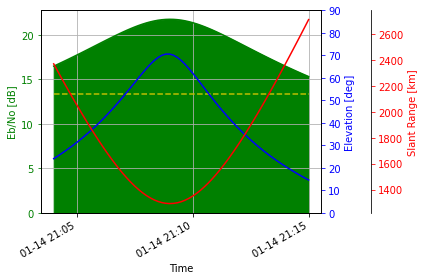

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

k = lp.LinkBudgetKeys
time = [n[k.time] for n in result]
ebno = [n[k.ebno_ratio] for n in result]
ebno_threshold = [n[k.ebno_ratio_threshold] for n in result]
slant_range = [n[k.slant_range]/1000 for n in result]

fig, ax1 = plt.subplots()
ax2, ax3, = ax1.twinx(), ax1.twinx()

ax1.plot(time, ebno, color='g')
ax1.fill_between(time, ebno, 0, color="g")
ax1.plot(time, ebno_threshold, "y--")
ax1.tick_params('y', colors='g')
ax1.set_ylabel("Eb/No [dB]", color="g")
ax1.set_ylim(0, max(filter(None, ebno)) + 1)

ax2.plot(time, elevation, color='b')
ax2.tick_params('y', colors='b')
ax2.set_ylabel("Elevation [deg]", color="b")
ax2.set_ylim(0, 90)

ax3.plot(time, slant_range, color='r')
ax3.tick_params('y', colors='r')
ax3.set_ylabel("Slant Range [km]", color="r")
ax3.spines["right"].set_position(("outward", 50))

ax1.set_xlabel("Time")
ax1.grid(True)
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
fig.autofmt_xdate()
fig.tight_layout()
plt.show()